In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/Kannada-MNIST/test.csv
/kaggle/input/Kannada-MNIST/train.csv
/kaggle/input/Kannada-MNIST/Dig-MNIST.csv
/kaggle/input/Kannada-MNIST/sample_submission.csv


In [2]:

#!pip install -q keras
#!pip install -q keract
#!pip install -q matplotlib
#!pip install -q sklearn
#!pip install -q numpy
#!pip install  imutils
#!pip install  Image
#!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

#%matplotlib inline 


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
from keras.layers import Conv2D, Dense,MaxPooling2D,Dropout,Flatten
from keras.models import Sequential
import keras

Using TensorFlow backend.


In [5]:
treinamento=pd.read_csv('/kaggle/input/Kannada-MNIST/train.csv')
teste=pd.read_csv('/kaggle/input/Kannada-MNIST/test.csv')

In [6]:
def ConvertCSVImage(frame):
  Y=frame['label']
  Y=np.array(Y)
  X=frame
  X=X.drop('label',axis=1)
  #del X['label']
  X=np.array(X)
  #print(X.shape)
  X=np.reshape(X, (X.shape[0], 28,28)) # C-like index ordering
  X=X/255
  Y=keras.utils.to_categorical(Y)

  return X,Y

In [7]:
X_train,Y_train=ConvertCSVImage(treinamento)
#X_test,Y_test=ConvertCSVImage(validacao)
X_test=X_train[50000:60000,]
Y_test=Y_train[50000:60000,]
X_train=X_train[0:50000,]
Y_train=Y_train[0:50000,]

In [8]:
input_shape=(28,28,1)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [9]:
epochs=10
batch_size=32
num_classes=10
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 95s 2ms/step - loss: 0.1384 - accuracy: 0.9582 - val_loss: 0.0370 - val_accuracy: 0.9888
Epoch 2/10
50000/50000 [==============================] - 96s 2ms/step - loss: 0.0488 - accuracy: 0.9856 - val_loss: 0.0235 - val_accuracy: 0.9920
Epoch 3/10
50000/50000 [==============================] - 96s 2ms/step - loss: 0.0373 - accuracy: 0.9887 - val_loss: 0.0238 - val_accuracy: 0.9924
Epoch 4/10
50000/50000 [==============================] - 95s 2ms/step - loss: 0.0268 - accuracy: 0.9919 - val_loss: 0.0281 - val_accuracy: 0.9912
Epoch 6/10
50000/50000 [==============================] - 95s 2ms/step - loss: 0.0244 - accuracy: 0.9928 - val_loss: 0.0309 - val_accuracy: 0.9917
Epoch 7/10
50000/50000 [==============================] - 94s 2ms/step - loss: 0.0234 - accuracy: 0.9933 - val_loss: 0.0330 - val_accuracy: 0.9916
Epoch 8/10
50000/50000 [==============================] - 95s 2ms/st

In [10]:
def GradCAM(model,imagearray,NClasses=1):
  #from keras.preprocessing import image
  import cv2 
  from PIL import Image
  #from keras.models import load_model
  import numpy as np
  #model=load_model(model)
  #img_size=img_size
  #img_size=img_size
  #img_size=list(img_size)
  #for j in range(0,(len(img_size)) ):
  #  img_size[j]=int(img_size[j])
  #img_size=tuple(img_size)  
  #Data = image.load_img(img_path, target_size=img_size) #(224,224)
  #Data = image.img_to_array(Data)
  #Data = np.expand_dims(Data, axis=0)
 # Data = preprocess_input(Data)

  #x=Data
  x=imagearray
  #x=x/255

  layer_names=[]
  cont=0
  Indices=[]
  for layers in model.layers:
    aux=type(layers)
    aux=str(aux)
    if "Conv2D" in aux:
      layer_names.append(layers.name)
      Indices.append(cont)
    cont=cont+1
  Indices=Indices[-1]

  preds = model.predict(x)
  class_idx = np.argmax(preds[0,])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.layers[Indices]#model.get_layer("block5_conv3")

  import keras.backend as K
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  #print(len(conv_layer_output_value[1,1,:]))
  for i in range(len(conv_layer_output_value[1,1,:])):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

 # from google.colab.patches import cv2_imshow

  #img = cv2.imread(img_path)
  heatmap = cv2.resize(heatmap, (28, 28))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img=0.6*imagearray + 0.4*heatmap
  #superimposed_img = cv2.addWeighted(imagearray, 0.6, heatmap, 0.4, 0)
  #cv2.imshow('Original',img)
  print(superimposed_img.shape)
  img=np.reshape(superimposed_img,(28,28,3))
  imagearray=np.reshape(imagearray,(28,28))
  #img = Image.fromarray(superimposed_img, 'RGB')
 # print("A classe Predita foi",class_idx)
  return(img,imagearray)
  #cv2_imshow(superimposed_img)
  #cv2.waitKey(0)
  #return(superimposed_img)

In [11]:

TesteX=teste
TesteX=TesteX.drop('id',axis=1)


In [12]:
TesteX=np.array(TesteX)
TesteX=np.reshape(TesteX, (TesteX.shape[0], 28,28,1)) # C-like index orderin

In [13]:
previsoes=model.predict(TesteX)

In [14]:
labels=[]
for i in range(0,previsoes.shape[0]):
  labels.append(np.argmax(previsoes[i,]))

In [15]:
PrevisoesFinais=pd.DataFrame([teste['id'].values,labels])

In [16]:
PrevisoesFinais=PrevisoesFinais.transpose()

In [17]:
PrevisoesFinais.columns = ['id', 'label']

In [18]:
PrevisoesFinais.to_csv('submission.csv', index=False)


Well we then trained a model and found our predictions but we can wonder why does the neural network tough of this answer?

To do so we utilize GradCam as defined above to vizualize which pixels were important in the image for top 1 classification

In [19]:
Indice=43
aux=TesteX[Indice,]
aux=np.reshape(aux,(1,aux.shape[0],aux.shape[1],aux.shape[2] ) )
aux.shape
Novo,Antigo=GradCAM(model,aux,1)


(1, 28, 28, 3)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


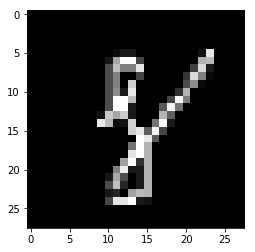

In [20]:
plt.imshow(Antigo,cmap='gray')

plt.show()

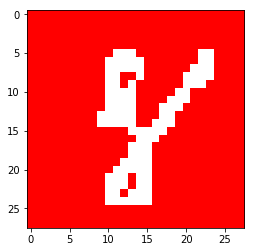

In [21]:
plt.imshow(Novo, interpolation='nearest')

plt.show()